# Optimal Private Minimim Spanning Trees using Input Perturbation

## General Information

Notebook to reproduce our experiments.

**Problem**: We consider the problem of privately releasing an MST for a graph $G$ where both the set of
vertices $V = \{1, ..., n\}$ and edges E are public, but we keep the weights $\vec{W}\in \mathbb{R}$ private.
We are using $\rho$-zCDP under the $\ell_\infty$ neighboring relationship with the following mechanisms:

## The Mechanisms

**PAMST** (Pinot 2018): Prim-based using the Report-Noisy-max with exponential noise $(n-1)$ times for selection.
returns $\arg\min_{e \in Cut} w_e + Exp(\frac{\epsilon}{2\Delta_\infty})$.

**Sealfon**: Uses the Post-Processing approach suggested by Sealfon. 
Releases the full noisy graph and hence returns $\vec{W} + N(0, \sigma^2)$ for $\sigma = \sqrt{\frac{n}{2\rho}}$ 

**We** Modification of Sealfon.
We add Gumble noise to each of the edges and therefore set $w_e' = \log(Exp(1)) + \lambda \cdot w_e$ where $\lambda = \sqrt{\frac{n-1}{2\cdot\rho}} \cdot 2 \cdot\Delta_\infty$



In [1]:
import logging
import math, sys
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.utils.extmath import safe_sparse_dot

import src.mst.mst_utilities as mst_util
import src.util.ioutils as ioutils
import src.mst.visualization_tools as mst_vis

# global configs
sns.set_style("ticks")
sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})

from src.util.logging_utils import init_logger
logger = init_logger(logging.INFO)
if sys.version_info[0:2] != (3, 9):
    logger.warning("This script has only been tested on python 3.9")

## Experiment 1: Complete Graph

The following uses a complete graph with edge weights uniformly drawn from $Uni(0,a)$ for some $a$.

 2024-11-24 14:07:00,559 - INFO - Loading from disk. file save/complete_n500_sens1_range0-50x.npy


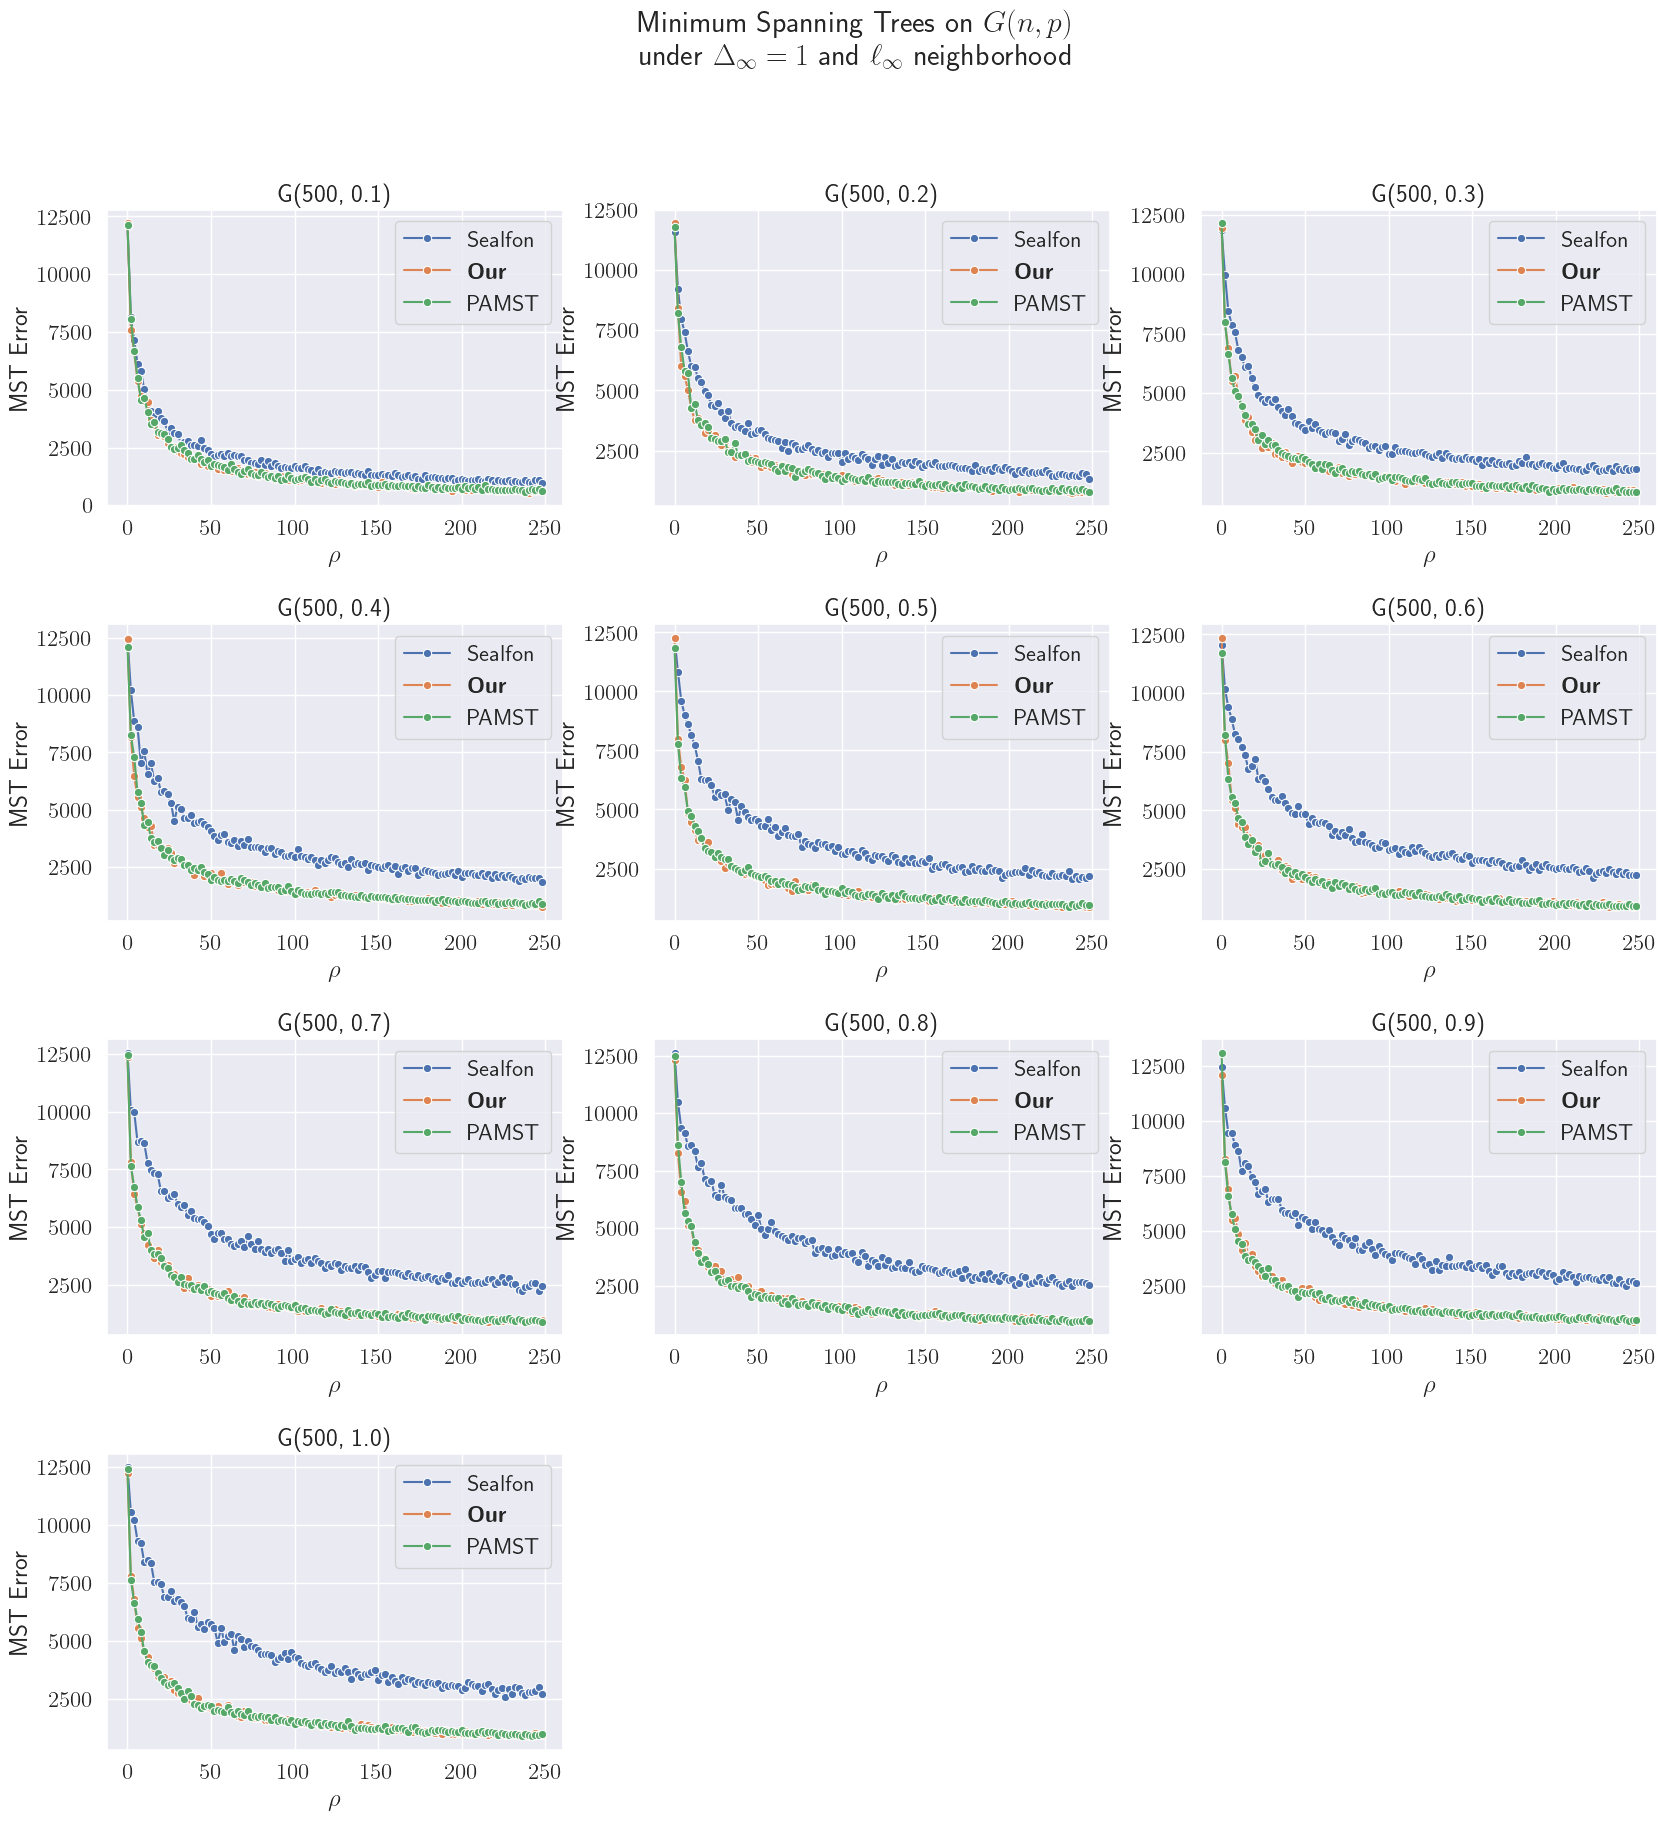

In [5]:
# Meta Parameters
load_from_disk = True
filename_to_load = "save/complete_n500_sens1_range0-50x.npy"
logging.getLogger('mst_utilities').setLevel(logging.DEBUG)

if load_from_disk:
    logger.info(f'Loading from disk. file {filename_to_load}')
    res = ioutils.load_results(filename=filename_to_load)
    (results_complete, edge_probabilities, rho_values, n, maximum_edge_weight, sensitivity) = \
        (res["results"], res["edge_probabilities"], res["rho_values"], res["n"], res["maximum_edge_weight"], res["sensitivity"])
else:
    # Parameters for Graph Structure
    n = 500
    maximum_edge_weight = 50 # upper limit of edge weight
    edge_probabilities = np.linspace(0.,1.0,10) # Graph Densitites
    # Privacy Parameters
    sensitivity = 1
    rho_values = np.arange(0.001, 250, 2)
    results_complete = []
    
    for edge_p in edge_probabilities:
        logger.debug(f'working on G({n},{edge_p}')
        if edge_p < np.log2(n)/n: logger.warning("Graph might not be connected as p < log(n)/n!")
        G = mst_util.generate_random_erdos_reny_graph(n, p=edge_p, max_edge_weight=maximum_edge_weight)
        results_complete += [mst_util.compute_approximate_dp(G=G, sensitivity=sensitivity, rho_values=rho_values)]
    logger.info("computation complete. Initializing the plots.")

# Initialized Plots
mst_vis.init_multiplot(results_complete, rho_values,
               meta_params={
                   'graph-size': n,
                   'title': "Minimum Spanning Trees on $G(n, p)$ \nunder $\\Delta_\\infty={}$ and $\\ell_\\infty$ neighborhood".format(sensitivity),
                    'edge_probabilities': edge_probabilities,
               }, columns=3)

# Saving the results if specified
if not load_from_disk:
    file_name = f'save/complete_n{n}_sens{sensitivity}_range0-{maximum_edge_weight}'
    ioutils.save_plot_and_data_experiment_one(file_name, results_complete, edge_probabilities, rho_values, n, maximum_edge_weight, sensitivity)

plt.show()

# Experiment 2: What is the Effect of the Density?

This experiment uses a $G(n, p)$ with $w_e \sim U(0, 100)$ to explore what the effect of the density is.
This is interesting because the noise for input privatization approach depends directly on the number $m$ of edges and ew expect a huger gap to our approach for denser graphs.
Chosen are also $\rho = 1$ and $\Delta_\infty = 0.1$.
As expected, Sealfons input privatization (post-processing) approach requires more noise noise for denser graphs and therefore, the gap between the other approaches increases.




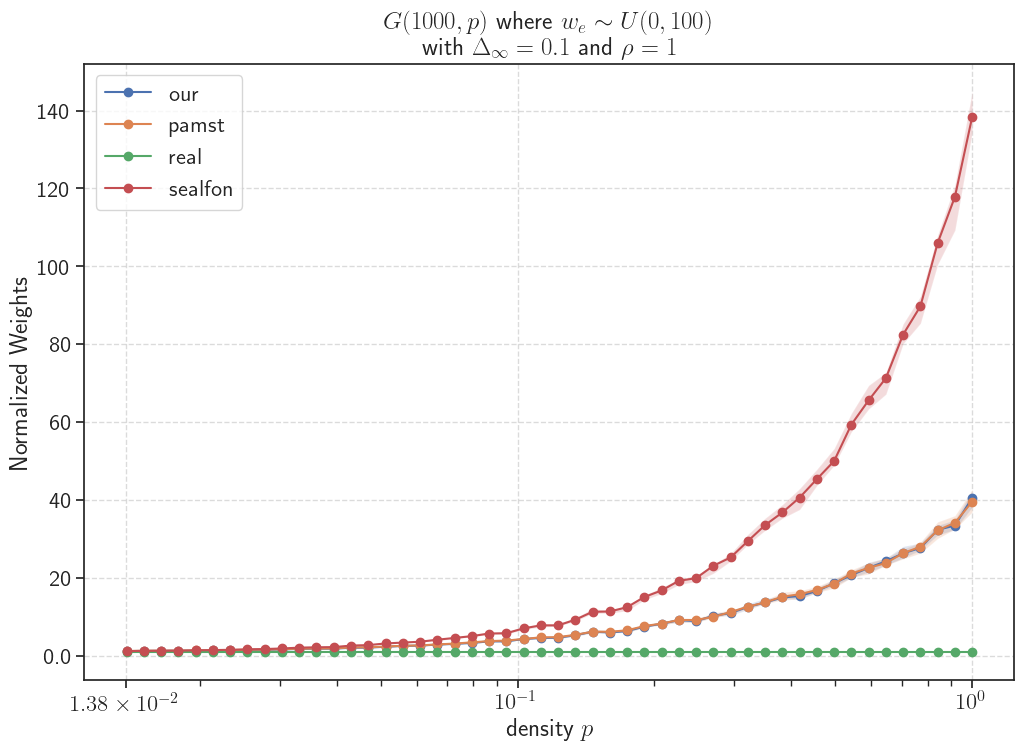

In [10]:
load_from_disk = True
filename_to_load = "save/exp-complete_densities_n1000_sens0.1_range0-100.npy"
logging.getLogger('src.mst.mst_utilities').setLevel(logging.DEBUG) # Temporarily increase log level.

if load_from_disk: # Loading an old run.
    old_results = ioutils.load_results(filename=filename_to_load)
    (results_complete, edge_probabilities, rho, n, maximum_edge_weight, sensitivity) = \
        (old_results["results"], old_results["edge_probabilities"], old_results["rho_values"], old_results["n"], old_results["maximum_edge_weight"], old_results["sensitivity"])
    df = pd.DataFrame(list(results_complete))
    
else: # rerunning the experiment.
    meta_params = n, sensitivity, maximum_edge_weight, rho, runs = 1000, 0.1, 100, [1], 10
    min_p = (2 * math.log(n))/n  # connected whp
    edge_probabilities = np.logspace(math.log2(min_p), math.log2(1), base=2, num=50) # log-spaced samples
    
    results_complete = mst_util.compute_different_densities_approximate_dp(n, edge_probabilities, sensitivity=sensitivity, maximum_edge_weight=maximum_edge_weight, rho=rho, number_of_runs=runs)
    df = pd.DataFrame(results_complete)

sns.set_style("ticks")
mst_vis.init_plot_densities(df=df, meta_params={'n': n,
                                                'max_edge_weight': maximum_edge_weight, 
                                                'edge_probabilities': edge_probabilities, 
                                                'rho': rho[0], 
                                                'sensitivity': sensitivity}, minx=round(math.log(n)/n*2, 4))
# Saving the results if specified
if not load_from_disk: 
    file_name = f'save/exp-complete_densities_n{n}_sens{sensitivity}_range0-{maximum_edge_weight}'
    ioutils.save_plot_and_data_experiment_one(file_name, results_complete, edge_probabilities, rho, n, maximum_edge_weight, sensitivity)


plt.savefig("save/exp2.pdf", format='pdf', bbox_inches='tight')
plt.show()


## Experiment 2: Instance Mutual information

Consider the following sample process, where we flip the bit $X_i$ with probability $0 < p < 1/2$:
$X_1,...X_n$ the following: $X_1=Ber(1/2)$ and $X_i = 1 - X_{i-1}$ w.p $0<p<\frac{1}{2}$ and $X_i$ otherwise.

The idea is that for a small $p$, the featues $X_i$ and $X_{i+1}$ will have mutual information 1 and vice versa for large $p$ values.
Furthermore, we also keep some decreasing mutual information between $X_i$ and $X_{i+k}$ as well - simulating some transitivities.

For this process we have a closed form describing the mutual information between two features which only depends on $p$ and their hop distance:
\begin{align}
W_{ij} = \left(\frac{1}{2}+\frac{1}{2}(1-2p)^k\right)\log_2 \left(1+(1-2p)^k\right) + \left(\frac{1}{2}-\frac{1}{2}\left(1-2p\right)^k\right)\log_2\left(1-(1-2p)^k)\right)
\end{align}
where $k = |i-j|$

The sensitivity parameter $\Delta_\infty = \log(V)/V$ chosen resembles an underlying dataset of size $V$

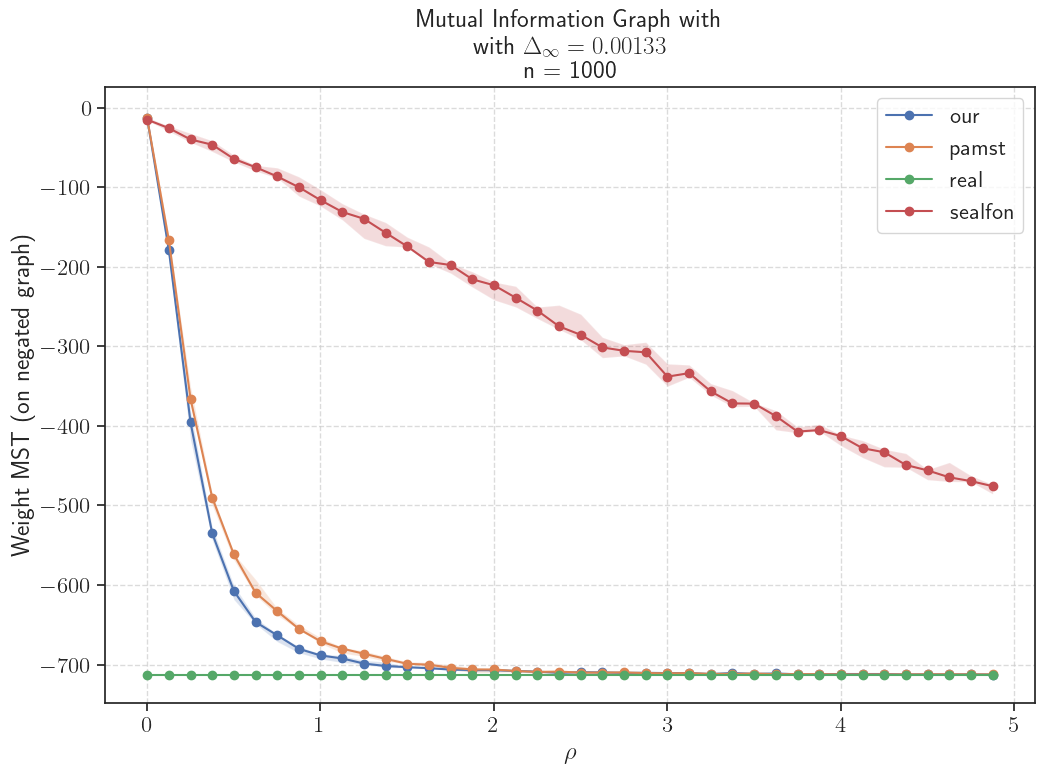

In [2]:
load_from_disk = True
file_name = "save/Nmi_n1000_flip-p0.05_sens0.00133"
logging.getLogger('src.mst.mst_utilities').setLevel(logging.DEBUG)

# Experimental Parameters
mutual_information = lambda dataset_size: np.log2(dataset_size)/dataset_size
rho_values = np.arange(0.001, 5, 1) # 5
flip_p = 0.01 # flips bit value: X_i = 1- X_{i-1} with probability p
n = 1500
runs = 1
sensitivity = round(mutual_information(dataset_size=10000),5) # MI for dataset of size 1000 

if load_from_disk:
    old_results = ioutils.load_results(filename=f'{file_name}.npy')
    (results, n, rho_values, flip_p, sensitivity) = \
        (old_results["results"], old_results["n"], old_results["rho_values"], old_results["flip_p"], old_results["sensitivity"])
else:
    results = []
    for i in range(runs):
        G = mst_util.generate_mi_instance(n, flip_p)
        results += [mst_util.compute_approximate_dp(G=G, sensitivity=sensitivity, rho_values=rho_values)]

if not load_from_disk:
    file_name = f'save/Mmi_n{n}_flip-p{flip_p}_sens{sensitivity}'
    ioutils.save_plot_and_data_experiment_two(file_name,results, rho_values, n, flip_p, sensitivity)

mst_vis.init_plot_exp_three(mst_vis.prepare_data_exp_three(results=results, rho_values=rho_values),
                            meta_params=dict(title="Test", sensitivity=sensitivity, n=n)) # Multiplot
plt.savefig(file_name + ".pdf", format='pdf', bbox_inches='tight')
plt.show()


# Experiment III: Hard-Instance from Sealfon
@Deprecated by now.

We are using Sealfons instance to create an hard instance. Not relevant at the moment.

 2024-11-13 13:05:06,522 - DEBUG - computing results
 2024-11-13 13:05:06,527 - INFO - computation complete. Initializing the plots.


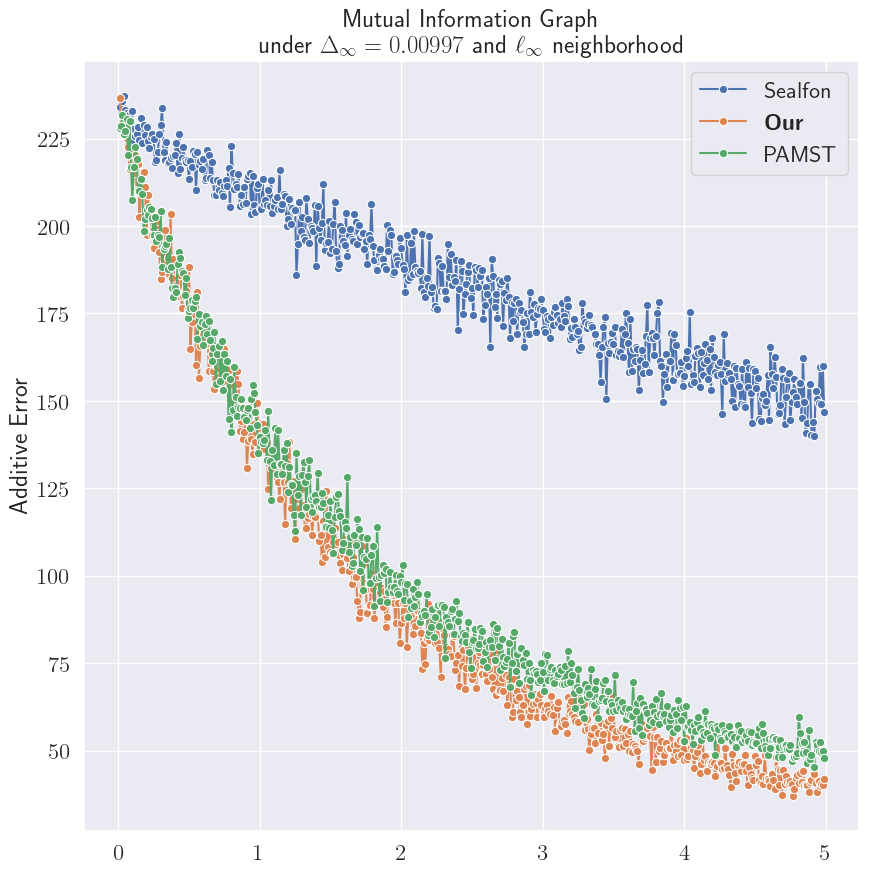

In [11]:
mutual_information = lambda db_size: np.log2(db_size)/db_size

# Meta Parameters
load_from_disk = False
filename_to_load = "save/mutual-information_n100_sens0.00997.npy"

if load_from_disk:
    logger.info(f'Loading from disk. file {filename_to_load}')
    res = ioutils.load_results(filename=filename_to_load)
    results_complete, rho_values, n, sensitivity =  (res["results"], res["rho_values"], res["n"], res["sensitivity"])
else:
    # Params
    rho_values = np.arange(0.01, 5, 0.01)
    flip_p = 0.01 # flips bit value: X_i = 1- X_{i-1} with probability p
    n = 300
    sensitivity = round(mutual_information(1000),5) # MI for dataset of size 1000 

    G = mst_util.generate_mi_instance(n, flip_p)
    results_mi = mst_util.compute_approximate_dp(G=G, sensitivity=sensitivity, rho_values=rho_values)
    
    logger.debug(f'computing results ...')
    logger.info(f'computation complete. Initializing the plots.')

# Initialized Plots
mst_vis.init_plot(results_mi, rho_values,
               meta_params={
                   'graph-size': n,
                   'title': "Mutual Information Graph \nunder $\\Delta_\\infty={}$ and $\\ell_\\infty$ neighborhood".format(sensitivity),
               })

# Saving the results if specified
if not load_from_disk:
    ioutils.save_plot_and_data_experiment_three(results_mi, rho_values, n, sensitivity)

plt.show()

Real MST Weight: 0
[255.88914266403188, 73.5649455387632, 50.96985726099633, 48.898288115691514, 40.195514048130924, 34.16505878569597, 31.81082745181895, 29.132528646722648, 27.275005516515087, 25.888733459683117, 23.241404955174975, 24.005504874179696, 23.533145255571643, 20.797337860565584, 21.92562109770431, 19.855406679112214, 18.290899885832246, 17.861791252409123, 17.803689066680995, 18.946081296922554, 17.6292836437288, 17.30887690144163, 16.712589523084713, 17.22781066524305, 16.195769814656874, 16.151579466303254, 15.0103480695772, 15.72490444887349, 12.868806022550247, 15.174911470724657]


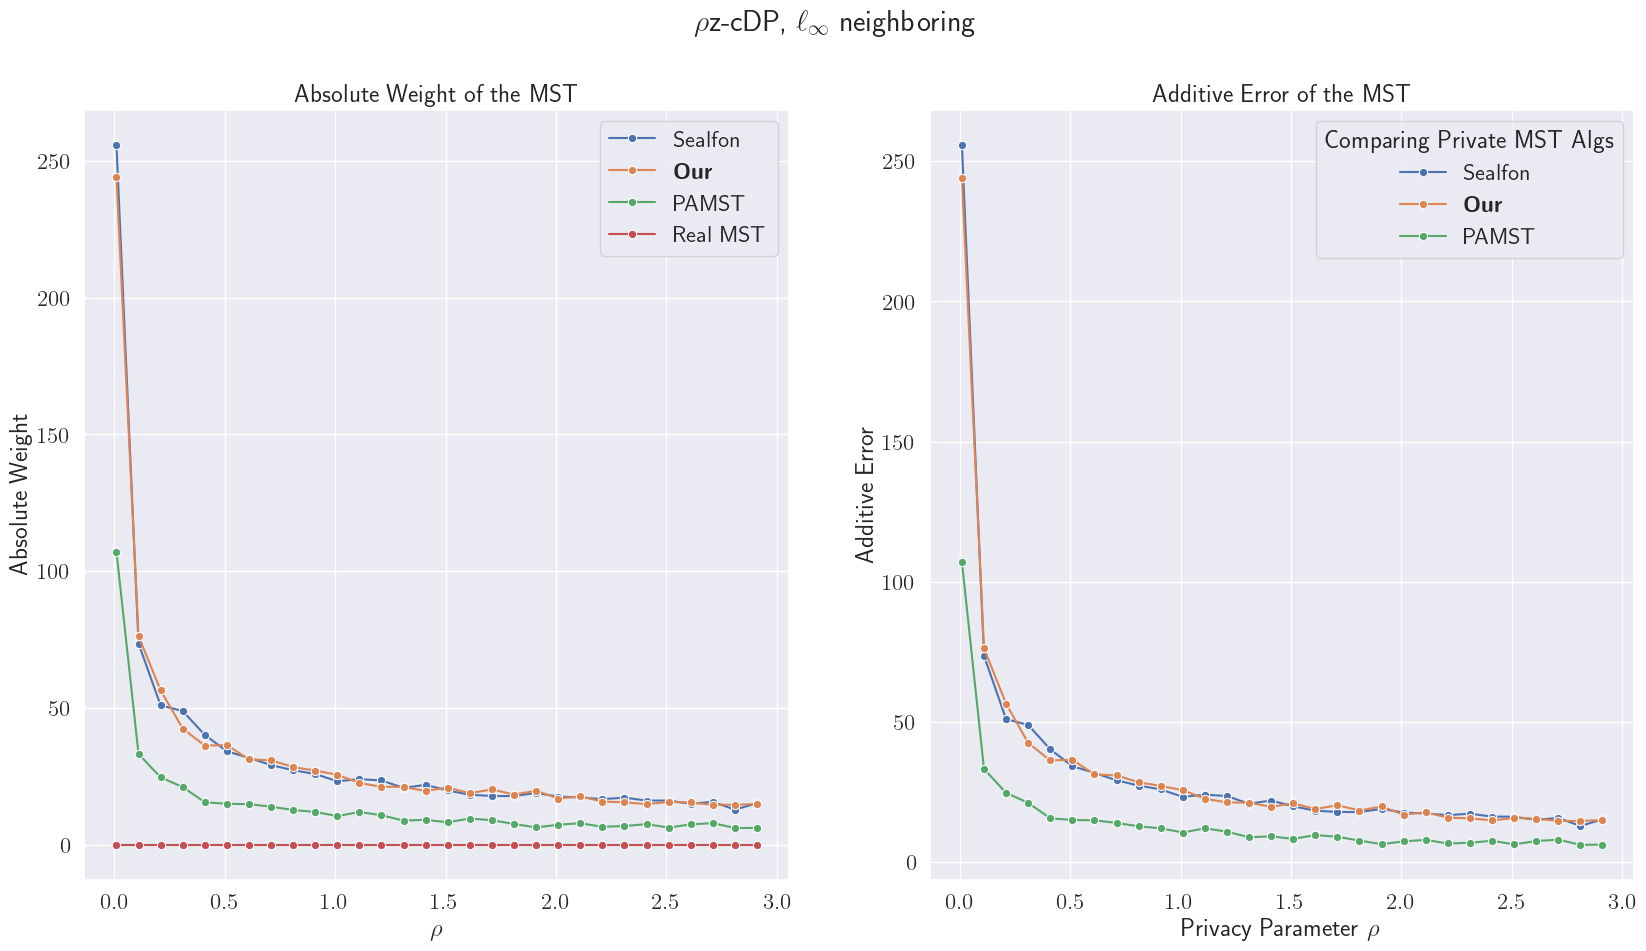

In [73]:
# Privacy Parameters
rho_values = np.arange(0.01, 3, 0.1)
# rho_values = [0.001,0.02]
n = 250
sensitivity = 1

# Generate a enw graph
G = {}
for rho in rho_values:
    G[rho] = mst_util.generate_hard_instance(n, 1/75* math.sqrt((n-1)/(2*rho))) # is this interesting?
    
# Computing the upper bound
upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n)/(2*rho)]
    
results = mst_util.compute_approximate_dp(G, sensitivity=sensitivity,rho_values=rho_values )
mst_vis.init_plot(results, rho_values=rho_values)
plt.show()

# Appendix

What comes now is more or less meant for experiments and debugging.

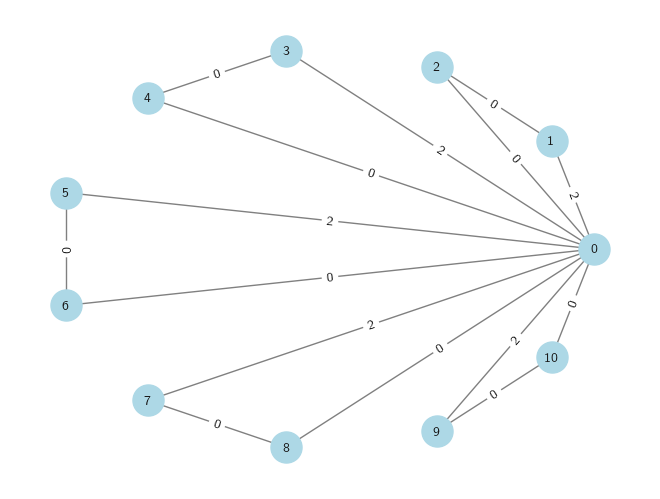

In [17]:
# Visualization of our hard instance
pos = nx.circular_layout(G)

G = mst_util.generate_hard_instance(5, 1)
T = nx.minimum_spanning_tree(G, algorithm='prim')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.show()


{(0,
  1): Text(-0.19882850523197593, -0.6345080300249896, '-0.5310044064107189'),
 (0,
  2): Text(-0.07087365393847175, -0.42955507614362737, '-0.3199229542717203'),
 (0,
  3): Text(-0.07888746877207485, -0.1447708110222666, '-0.19837089841438815'),
 (0, 4): Text(-0.2550781373439255, 0.1455830414045582, '-0.12465597028668723'),
 (1, 2): Text(0.13274301768718427, -0.3552291889777333, '-0.5310044064107189'),
 (1,
  3): Text(0.12472920285358119, -0.07044492385637255, '-0.3199229542717203'),
 (1,
  4): Text(-0.051461465718269456, 0.21990892857045224, '-0.19837089841438815'),
 (2, 3): Text(0.2526840541470854, 0.13450803002498965, '-0.5310044064107189'),
 (2, 4): Text(0.07649338557523473, 0.42486188245181444, '-0.3199229542717203'),
 (3, 4): Text(0.06847957074163163, 0.7096461475731752, '-0.5310044064107189')}

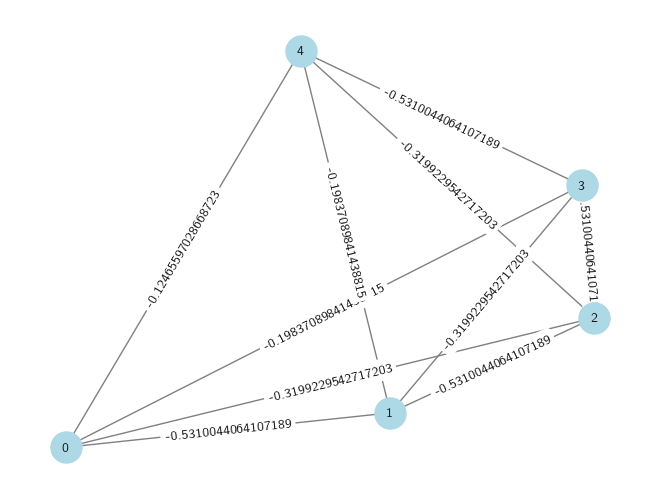

In [10]:
# Visualization MI Cell

G2 = mst_util.generate_mi_instance(5, 0.1
                                   )
pos = nx.spiral_layout(G2)

# Draw the graph
nx.draw(G2, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_size=10)


{(2,
  87): Text(0.028386192611077474, -0.03680606473560579, '11.283129444099504'),
 (2, 452): Text(0.10283734213618602, 0.20502737025565118, '83.06093301418045'),
 (7,
  448): Text(0.21751571025307892, -0.06152562943038118, '83.49389659232679'),
 (10,
  973): Text(0.14920686623726626, 0.46484820932235127, '54.931519391042606'),
 (16,
  608): Text(0.21665083066785384, -0.2328016054103536, '29.21490439870752'),
 (23,
  117): Text(-0.058436649634148005, 0.003664341571614429, '15.955052815985793'),
 (40,
  968): Text(0.4365867995967684, -0.21237762864912216, '88.33017329995448'),
 (41, 900): Text(0.3015955432097293, 0.3579106632494096, '57.13589334347352'),
 (69, 793): Text(0.20737170870365634, 0.3250253948604296, '62.9827157483263'),
 (70, 810): Text(0.3288184263662964, 0.2588351098145206, '20.25130597311958'),
 (73,
  904): Text(-0.24736667629190154, 0.3718087877084087, '1.735005647430432'),
 (80,
  512): Text(-0.2929296608413421, -0.023679282700578785, '34.363369839152035'),
 (84,
  16

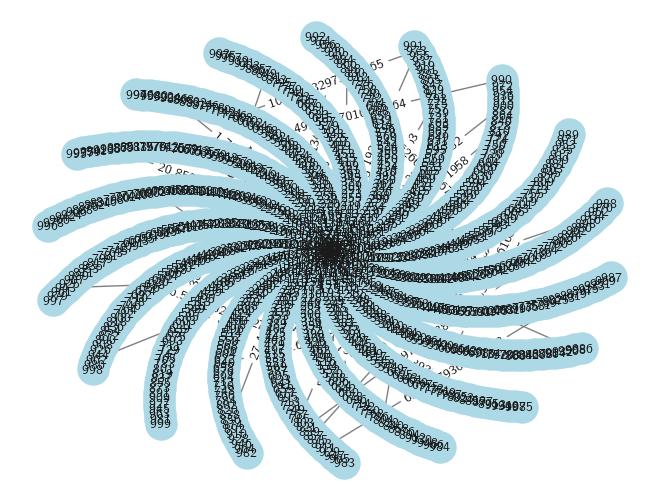

In [3]:
G3 = mst_util.generate_random_erdos_reny_graph(1000, 0.0001, 100, False)

pos = nx.spiral_layout(G3)
edge_labels = nx.get_edge_attributes(G3, 'weight')
# print(nx.number_of_edges(G3))

nx.draw(G3, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')
# nx.draw_networkx_edge_labels(G3, pos, edge_labels=edge_labels, font_size=10)
